`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   

**Выполнила Холькина Анна, 3 вариант**


# Лабораторная работа №3: Линейные модели. Кросс-валидация. 

В практических примерах ниже показано:   

* как пользоваться инструментами предварительного анализа для поиска линейных взаимосвязей 
* как строить и интерпретировать линейные модели с логарифмами  
* как оценивать точность моделей с перекрёстной проверкой (LOOCV, проверка по блокам)

*Модели*: множественная линейная регрессия 

*Данные*: `boston_for_lab` (источник: <https://github.com/aksyuk/MTML/blob/main/Labs/data/Boston_for_lab.csv>)

`crim` - уровень преступности на душу населения по району;

`zn` – доля земли под жилую застройку, зонированная под участки более 25000 кв. футов;

`indus` – доля акров, не связанных с розничной торговлей, на город;

`chas` – фиктивная переменная реки Чарльз: 1, если участок ограничивает реку, 0 в противном случае);

`nox` – концентрация оксидов азота (частей на 10 миллионов);

`rm` – среднее количество комнат в доме;

`age` – доля жилых единиц, построенных до 1940 г., занимаемых владельцами;

`dis` – средневзвешенное расстояние до пяти бостонских центров занятости;

`rad` – индекс доступности радиальных магистралей;

`tax` – полная ставка налога на имущество \ на 10000 долларов;

`ptratio` – соотношение учеников и учителей по районам;

`black` – 1000 (Bk - 0,63) ^ 2, где Bk - доля черных по городам;

`lstat` – доля населения с самым низким статусом (в процентах);

`medv` – медианная стоимость домов, занимаемых владельцами, в тысячах долларов;

`tax_over_400` – фиктивная переменная: 1 если полная ставка налога на имущество \ на 10000 долларов превышает 400.

### Зависимая и объясняющие переменные

`medv` - зависимая

`rm`, `dis`, `tax_over_400` - объясняющие

In [301]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Указания к выполнению


## Загружаем пакеты

In [302]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

In [303]:
# константы
#  ядро для генератора случайных чисел
my_seed = 3
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

## Загружаем данные

Набор данных `insurance` в формате .csv доступен для загрузки по адресу: <https://raw.githubusercontent.com/aksyuk/R-data/master/other%20sources/insurance.csv>. Справочник к данным можно найти по адресу: <https://github.com/aksyuk/R-data/blob/master/other%20sources/CodeBook_insurance.md>.  
Загружаем данные во фрейм и кодируем категориальные переменные.  

In [304]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/Boston_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (506, 15)


In [305]:
# первые 5 строк фрейма
DF_raw.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,tax_over_400
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,0


In [306]:
# типы столбцов фрейма
DF_raw.dtypes

crim            float64
zn              float64
indus           float64
chas              int64
nox             float64
rm              float64
age             float64
dis             float64
rad               int64
tax               int64
ptratio         float64
black           float64
lstat           float64
medv            float64
tax_over_400      int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [307]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

crim            0
zn              0
indus           0
chas            0
nox             0
rm              0
age             0
dis             0
rad             0
tax             0
ptratio         0
black           0
lstat           0
medv            0
tax_over_400    0
dtype: int64

Пропусков не обнаружено.  

Прежде чем переходить к анализу данных, разделим фрейм на две части: одна (80%) станет основой для обучения моделей, на вторую (20%) мы сделаем прогноз по лучшей модели.  

In [308]:
DF_raw = DF_raw[['rm', 'dis', 'medv', 'tax_over_400']]
DF_raw.head()

,rm,dis,medv,tax_over_400
0,6.575,4.0900,24.0,0
1,6.421,4.9671,21.6,0
2,7.185,4.9671,34.7,0
3,6.998,6.0622,33.4,0
4,7.147,6.0622,36.2,0


In [309]:
# данные для построения моделей
DF = DF_raw.sample(frac=0.8, random_state=my_seed)

# данные для прогнозов
DF_predict = DF_raw.drop(DF.index)

In [310]:
DF.head(10)

,rm,dis,medv,tax_over_400
224,8.266,2.8944,44.8,0
137,6.454,1.8498,17.1,1
453,7.393,2.4527,17.8,1
303,6.982,5.4917,33.1,0
254,6.108,9.2203,21.9,0
37,5.850,3.9342,21.0,0
442,6.219,2.0048,18.4,1
417,5.304,1.6475,10.4,1
16,5.935,4.4986,23.1,0
209,5.344,3.8750,20.0,0


In [311]:
DF_predict.head(10)

,rm,dis,medv,tax_over_400
0,6.575,4.0900,24.0,0
1,6.421,4.9671,21.6,0
2,7.185,4.9671,34.7,0
7,6.172,5.9505,27.1,0
20,5.570,3.7979,13.6,0
26,5.813,4.6820,16.6,0
28,6.495,4.4547,18.4,0
33,5.701,3.7872,13.1,0
36,5.841,3.3779,20.0,0
48,5.399,5.8700,14.4,0


## Предварительный анализ данных   

### Считаем описательные статистики   

Рассчитаем описательные статистики для непрерывных переменных. Из таблицы ниже можно видеть, что переменная `charges`, которая является зависимой переменной модели, сильно отличается по масштабу от всех остальных.    Также заметим, что из всех объясняющих только переменная `children` принимает нулевые значения. Остальные показатели положительны.  

In [312]:
# описательные статистики для непрерывных переменных
DF[['medv', 'rm', 'dis']].describe()

,medv,rm,dis
count,405.000000,405.000000,405.000000
mean,22.818025,6.307106,3.853775
std,9.285923,0.705691,2.120524
min,6.300000,3.561000,1.137000
25%,17.400000,5.927000,2.106900
50%,21.400000,6.229000,3.279700
75%,25.200000,6.635000,5.287300
max,50.000000,8.780000,12.126500


### Строим графики  

Посмотрим на графики взаимного разброса непрерывных переменных. 

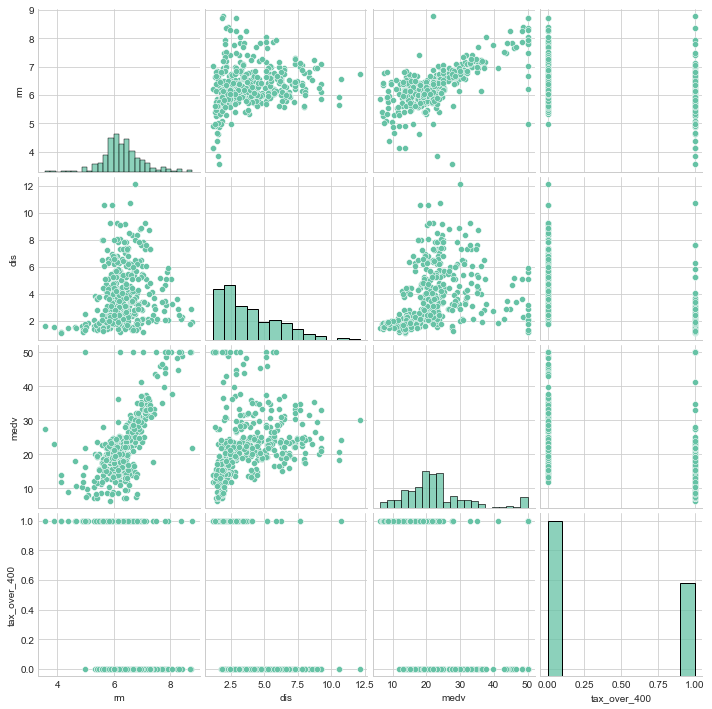

In [313]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['rm', 'dis', 'medv', 'tax_over_400']])
plt.show()

Судя по этим графикам:  
* `tax_over_400` дискретна, остальные непрерывны;
* распределение зависимой `medv` не является нормальным;  
* из всех объясняющих нормально распределена только `rm`;  
* прослеживается линейная связь у `medv` и `rm`, но есть сильно отклоняющиеся точки. Скорее всего, связь будет умеренной.

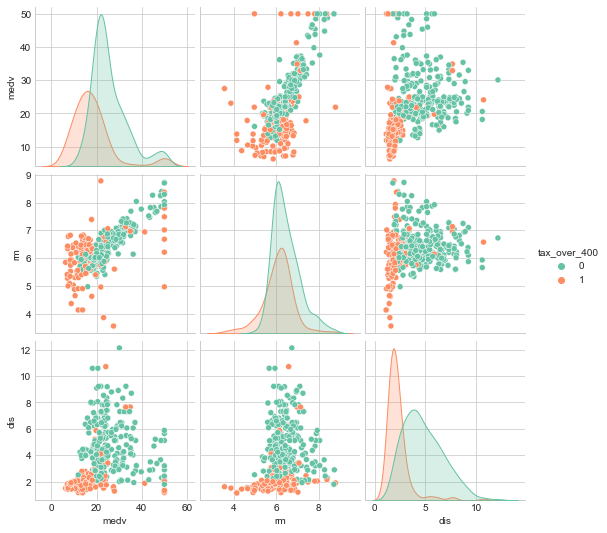

In [314]:
sns.pairplot(DF[['medv', 'rm', 'dis', 'tax_over_400']],
            hue='tax_over_400')

plt.show()

Посмотрим на корреляционные матрицы непрерывных переменных фрейма. 

In [315]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['medv', 'rm', 'dis']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,medv,rm,dis
medv,1.00,0.70,0.22
rm,0.70,1.00,0.18
dis,0.22,0.18,1.00


Посчитаем корреляционные матрицы для тех, чья полная ставка налога на имущество \ на $10000 превышает 400 (фиктивная переменная = 1)

In [316]:
corr_mat = DF.loc[DF['tax_over_400'] == 1][['medv', 'rm', 'dis']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,medv,rm,dis
medv,1.00,0.39,0.18
rm,0.39,1.00,0.25
dis,0.18,0.25,1.00


Посчитаем корреляционные матрицы для тех, чья полная ставка налога на имущество \ на $10000 не превышает 400 (фиктивная переменная = 0)

In [317]:
corr_mat = DF.loc[DF['tax_over_400'] == 0][['medv', 'rm', 'dis']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,medv,rm,dis
medv,1.00,0.90,-0.08
rm,0.90,1.00,-0.04
dis,-0.08,-0.04,1.00


**Вывод:** стоимость домов сильно зависит от количества комнат в доме, если полная ставка налога на имущество \ на $10000 не превышает 400. Если привышает, корреляция почти в два раза меньше. 



### Логарифмируем зависимую переменную  

Важным допущением линейной регрессии является нормальность зависимой переменной. Чтобы добиться нормального распределения, используют логарифмирование либо преобразование Бокса-Кокса. В этой лабораторной остановимся на логарифмировании.   

In [318]:
# логарифмируем зависимую переменную
DF['log_medv'] = np.log(DF['medv'])
# DF_predict['log_medv'] = np.log(DF_predict['medv'])
# описательные статистики для непрерывных показателей
# DF[['charges', 'log_charges', 'age', 'bmi', 'children']].describe()

Проведём формальные тесты на нормальность.  

In [319]:
# тестируем на нормальность
for col in ['medv', 'log_medv']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

medv Statistics=0.91, p=0.0000
Распределение не нормально (H0 отклоняется)

log_medv Statistics=0.98, p=0.0000
Распределение не нормально (H0 отклоняется)



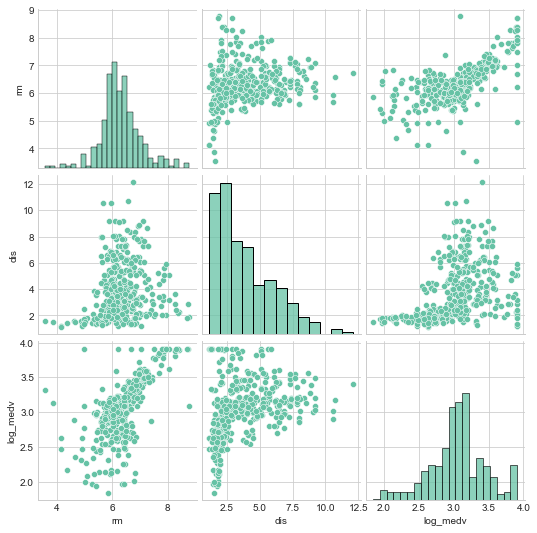

In [320]:
sns.pairplot(DF[['rm', 'dis', 'log_medv']])
plt.show()

Логарифмирование меняет взаимосвязи между переменными.   

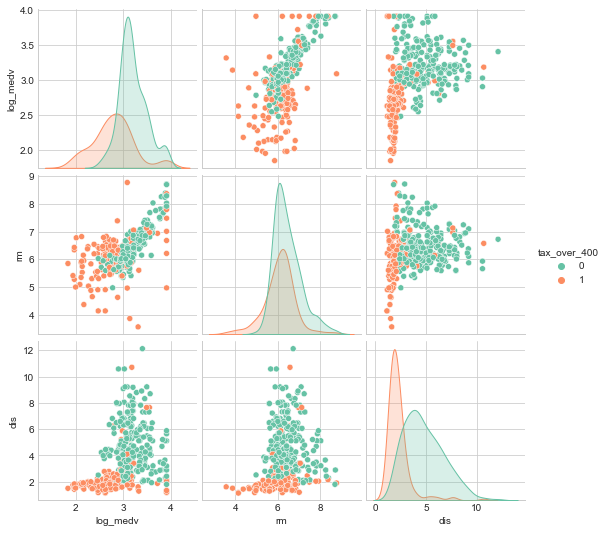

In [321]:
sns.pairplot(DF[['log_medv', 'rm', 'dis', 'tax_over_400']], hue='tax_over_400')
plt.show()

In [322]:
corr_mat = DF[['medv', 'log_medv', 'rm', 'dis']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,medv,log_medv,rm,dis
medv,1.00,0.96,0.70,0.22
log_medv,0.96,1.00,0.64,0.33
rm,0.70,0.64,1.00,0.18
dis,0.22,0.33,0.18,1.00


Связь между объясняющей переменной `rm` и прологарифмированной зависимой `log_medv` стала слабее.

In [323]:
corr_mat = DF.loc[DF['tax_over_400'] == 1][['medv', 'log_medv', 'rm', 'dis']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,medv,log_medv,rm,dis
medv,1.00,0.94,0.39,0.18
log_medv,0.94,1.00,0.37,0.27
rm,0.39,0.37,1.00,0.25
dis,0.18,0.27,0.25,1.00


In [324]:
corr_mat = DF.loc[DF['tax_over_400'] == 0][['medv', 'log_medv', 'rm', 'dis']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,medv,log_medv,rm,dis
medv,1.00,0.98,0.90,-0.08
log_medv,0.98,1.00,0.87,-0.04
rm,0.90,0.87,1.00,-0.04
dis,-0.08,-0.04,-0.04,1.00


Также произошло и для дискретной объясняющей переменной `tax_over_400`. Это значит, что ошибка модели на обучающей выборке с прологарифмированной зависимой переменной будет немного больше, чем с изначальной. Let's check it.

## Строим модели регрессии

### Спецификация моделей  
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:  

1. `fit_lm_1`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot rm + \hat{\beta_3} \cdot dis$
1. `fit_lm_2`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot rm \cdot tax\_over\_400 + \hat{\beta_3} \cdot bmi$
1. `fit_lm_3`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot dis \cdot tax\_over\_400 + \hat{\beta_3} \cdot rm$
1. `fit_lm_4`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot dis \cdot tax\_over\_400 + \hat{\beta_3} \cdot rm \cdot tax\_over\_400$

1. `fit_lm_1_log`: то же, что `fit_lm_1`, но для зависимой $\hat{log\_medv}$  
1. `fit_lm_2_log`: то же, что `fit_lm_2`, но для зависимой $\hat{log\_medv}$
1. `fit_lm_3_log`: то же, что `fit_lm_3`, но для зависимой $\hat{log\_medv}$
1. `fit_lm_4_log`: то же, что `fit_lm_4`, но для зависимой $\hat{log\_medv}$ 


### Обучение и интерпретация  

Создаём матрицы значений объясняющих переменных ( $X$ ) и вектора значений зависимой ( $y$ ) для всех моделей.  

In [325]:
# данные для моделей 1, 5
df1 = DF[['medv', 'tax_over_400', 'rm', 'dis']]

# данные для моделей 2, 6
df2 = DF[['medv', 'tax_over_400', 'rm', 'dis']]
df2.loc[:, 'rm_tax_over_400'] = df2.loc[:, 'rm'] * df2.loc[:, 'tax_over_400']
df2 = df2.drop(['rm'], axis=1)

# данные для моделей 3, 7
df3 = DF[['medv', 'tax_over_400', 'rm', 'dis']]
df3.loc[:, 'dis_tax_over_400'] = df3.loc[:, 'dis'] * df3.loc[:, 'tax_over_400']
df3 = df3.drop(['dis'], axis=1)

# данные для моделей 4, 8
df4 = DF[['medv', 'tax_over_400', 'rm', 'dis']]
df4.loc[:, 'rm_tax_over_400'] = df4.loc[:, 'rm'] * df4.loc[:, 'tax_over_400']
df4.loc[:, 'dis_tax_over_400'] = df4.loc[:, 'dis'] * df4.loc[:, 'tax_over_400']
df4 = df4.drop(['rm', 'dis'], axis=1)

# данные для моделей 9, 10
df0 = DF.drop(['log_medv'], axis=1)

In [326]:
# проверка результатов
df0.head(5)

,rm,dis,medv,tax_over_400
224,8.266,2.8944,44.8,0
137,6.454,1.8498,17.1,1
453,7.393,2.4527,17.8,1
303,6.982,5.4917,33.1,0
254,6.108,9.2203,21.9,0


Построим модели от всех объясняющих переменных на всех наблюдениях `DF`, чтобы проинтерпретировать параметры. В модели для зависимой переменной `medv` интерпретация стандартная:  

1. Константа – базовый уровень зависимой переменной, когда все объясняющие равны 0.  
2. Коэффициент при объясняющей переменной $X$ показывает, на сколько своих единиц измерения изменится $Y$, если $X$ увеличится на одну свою единицу измерения.  

In [327]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df0.drop(['medv'], axis=1)
y = df0.medv.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель fit_lm_0:
 константа  [-28.11] 
 объясняющие  ['rm', 'dis', 'tax_over_400'] 
 коэффициенты  [[ 8.435 -0.14  -4.62 ]]


In [328]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
np.sqrt(MSE)

array([6.34460588])

С интерпретацией модели на логарифме $Y$ дела обстоят сложнее:  
1. Константу сначала надо экспоненциировать, далее интерпретировать как для обычной модели регрессии.  
1. Коэффициент при $X$ нужно экспоненциировать, затем вычесть из получившегося числа 1, затем умножить на 100. Результат показывает, на сколько процентов изменится (увеличится, если коэффициент положительный, и уменьшится, если отрицательный) зависимая переменная, если $X$ увеличится на одну свою единицу измерения.  

In [329]:
# модель со всеми объясняющими, y_log
X = df0.drop(['medv'], axis=1)
y = np.log(df0.medv).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)
print('модель fit_lm_0_log:\n', 
      'константа ', np.around(fit_lm_0_log.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [1.153] 
 объясняющие  ['rm', 'dis', 'tax_over_400'] 
 коэффициенты  [[ 0.312  0.008 -0.265]]


In [330]:
# пересчёт коэффициентов для их интерпретации
np.around((np.exp(fit_lm_0_log.coef_) - 1) * 100, 1)

array([[ 36.5,   0.8, -23.3]])

In [331]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0_log.predict(X)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
np.sqrt(MSE_log)

array([6.01221498])

In [332]:
print('MSE_train модели для medv меньше MSE_train',
     'модели для log(medv) в ', np.around(MSE_log / MSE, 1), 'раз')

MSE_train модели для medv меньше MSE_train модели для log(medv) в  [0.9] раз


Действительно. Так произошло, потому что корреляция стала меньше для объясняющих переменных и прологарифмированной зависимой.

### Оценка точности

#### LOOCV  

Сделаем перекрёстную проверку точности моделей по одному наблюдению.  

In [333]:
# LeaveOneOut CV
loo = LeaveOneOut()

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['medv'], axis=1)
    y = df.medv
    score = cross_val_score(lm, X, y, cv=loo,
                           scoring='neg_mean_squared_error').mean()    
    scores.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 9.38 секунд


In [334]:
df0.shape

(405, 4)

In [335]:
# модели для y_log
scores_log = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['medv'], axis=1)
    y = np.log(df.medv)
    score = cross_val_score(lm, X, y, cv=loo, n_jobs=1,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 8.81 секунд


Сравним ошибки для моделей на исходных значениях `medv` с ошибками моделей на логарифме.  

In [336]:
scores

[-41.49864928613883,
 -41.49864928613882,
 -70.30225703028975,
 -41.70585454787725,
 -70.16101822914963]

In [337]:
[np.around(-x, 2) for x in scores]

[41.5, 41.5, 70.3, 41.71, 70.16]

In [338]:
[np.around(-x, 5) for x in scores_log]

[0.07972, 0.07972, 0.11672, 0.07881, 0.11469]

Определим самые точные модели отдельно на `medv` и на `log_medv`.  

In [339]:
# самая точная на medv
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_loocv =', np.around(-max(scores), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_1 :
MSE_loocv = 41.499


In [340]:
# самая точная на log(medv)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_loocv =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_3_log :
MSE_loocv = 0.079


#### Перекрёстная проверка по блокам    

Теоретически этот метод менее затратен, чем LOOCV. Проверим на наших моделях.   

In [341]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['medv'], axis=1)
    y = df.medv
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.23 секунд


In [342]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores_log = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['medv'], axis=1)
    y = np.log(df.medv)
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.24 секунд


In [343]:
scores

[-41.193115597557515,
 -41.28898131765577,
 -70.89687604590615,
 -42.077879753966386,
 -69.24676146041422]

In [344]:
[np.around(-x, 2) for x in scores]

[41.19, 41.29, 70.9, 42.08, 69.25]

In [345]:
# самая точная на medv
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_kf10 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0 :
MSE_kf10 = 41.0


In [346]:
[np.around(-x, 5) for x in scores_log]

[0.07923, 0.07925, 0.11873, 0.07927, 0.11295]

In [347]:
# самая точная на log(medv)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_kf10 =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0_log :
MSE_kf10 = 0.079


Самой точной среди моделей для `medv` оказалась `fit_lm_0`, а среди моделей для `medv_log` – `fit_lm_0_log`. Оценим точность прогноза по этим моделям на отложенные наблюдения.   

In [348]:
# прогноз по fit_lm_0
#  модель на всех обучающих наблюдениях
X = df0.drop(['medv'], axis=1)
y = df0.medv.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['medv']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['medv'], axis=1)

#  прогнозы
y_pred = fit_lm_0.predict(X)

# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_0 на отложенных наблюдениях = 36.37


In [349]:
y_pred[:10]

array([[26.77844657],
       [25.35649209],
       [31.80103091],
       [23.11829008],
       [18.34194746],
       [20.26781025],
       [26.05251353],
       [19.44846614],
       [20.68676542],
       [16.60911588]])

In [350]:
# прогноз по fit_lm_log_0
# модель
X = df0.drop(['medv'], axis=1)
y = np.log(df0.medv).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['medv']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['medv'], axis=1)

#  прогнозы
y_pred = fit_lm_0_log.predict(X)

# ошибка
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0_log на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_0_log на отложенных наблюдениях = 33.48


In [351]:
y_pred[:10]

array([[3.23366725],
       [3.19272098],
       [3.43070949],
       [3.12303332],
       [2.91826684],
       [3.00104344],
       [3.21166809],
       [2.95898806],
       [2.99932019],
       [2.8815965 ]])

In [352]:
np.around(np.sqrt(MSE) / np.mean(DF_predict[['medv']]) * 100, 1)

medv    28.2
dtype: float64

In [353]:
np.around(np.sqrt(MSE_log) / np.mean(DF_predict[['medv']]) * 100, 1)

medv    27.1
dtype: float64

Очевидно, на выборке для прогноза точнее модель `fit_lm_0_log`: она содержит все объясняющие переменные.

In [354]:
X = df0.drop(['medv'], axis=1)
y = np.log(df0.medv).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['medv']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['medv'], axis=1)

#  прогнозы
y_pred = fit_lm_0_log.predict(X)

print('модель fit_lm_0_log:\n', 
      'константа ', np.around(fit_lm_0_log.intercept_, 3),
      '\n объясняющие ', list(df0.drop(['medv'], axis=1).columns.values),
      '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [1.153] 
 объясняющие  ['rm', 'dis', 'tax_over_400'] 
 коэффициенты  [[ 0.312  0.008 -0.265]]


Для интерпретации параметров прологарифмированной модели необходимо их экспоненциировать.

In [355]:
const_exp = np.exp(fit_lm_0_log.intercept_)
coef_exp = np.exp(fit_lm_0_log.coef_)

In [356]:
coef_exp_final = [(x-1)*100 for x in coef_exp]

In [357]:
print('Константа:', float(np.around(const_exp, 3)))

Константа: 3.167


In [358]:
print('Объясняющие:', list(df0.drop(['medv'], axis=1).columns.values),
      '\nКоэффициенты:', (np.around(coef_exp_final, 3)))

Объясняющие: ['rm', 'dis', 'tax_over_400'] 
Коэффициенты: [[ 36.548   0.804 -23.255]]


## Интерпретация параметров модели

Y = 3.167 + 36.548rm + 0.804dis - 23.255tax_over_400

1. Ошибка модели на отложенных наблюдениях составила **27.1%** от среднего значения Y
2. Если объясняющие переменные будут равняться нулю, то Y равен константе = 3.167.
3. При увеличении `rm` на единицу, Y увеличится на **36.548**. При увеличении `dis` на единицу, Y увеличится на **0.804**. При значении дискретной переменной `tax_over_400 = 1`, Y уменьшается на **23.255**, а при значении равном нулю, значение Y зависит только от непрерывных переменных.

Проверим нашу модель на выборке.

In [369]:
DF_predict.head(10)

,rm,dis,medv,tax_over_400
0,6.575,4.0900,24.0,0
1,6.421,4.9671,21.6,0
2,7.185,4.9671,34.7,0
7,6.172,5.9505,27.1,0
20,5.570,3.7979,13.6,0
26,5.813,4.6820,16.6,0
28,6.495,4.4547,18.4,0
33,5.701,3.7872,13.1,0
36,5.841,3.3779,20.0,0
48,5.399,5.8700,14.4,0


In [368]:
y_pred = fit_lm_0_log.predict(X[:10])
np.exp(y_pred)

array([[25.37253398],
       [24.35460572],
       [30.89855718],
       [22.71517758],
       [18.50918022],
       [20.10650587],
       [24.82045456],
       [19.27845334],
       [20.07188719],
       [17.84273642]])

Можно заметить, что значения Y в отложенной выборке и предсказанные моделью значения довольно схожи.

# Источники 

1. *James G., Witten D., Hastie T. and Tibshirani R.*  An Introduction to Statistical Learning with Applications in R. URL: [http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf](https://drive.google.com/file/d/15PdWDMf9hkfP8mrCzql_cNiX2eckLDRw/view?usp=sharing)     
1. Рашка С. Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.
1. Interpreting Log Transformations in a Linear Model / virginia.edu. URL: <https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/>  
1. Python Timer Functions: Three Ways to Monitor Your Code / realpython.com. URL: <https://realpython.com/python-timer/>  